In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
import networkx as nx
import sys
import random
sys.path.append('../src/')
from random_graph import RandGraph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

## Model

In [200]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

c:\users\girardotm\appdata\local\continuum\anaconda2\envs\graph_ml_problems\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Input is a vector of nodes' congestion  in the current state. Output is the action vector.

In [201]:
state_size = 10
action_size = 10

In [202]:
model = Sequential()
model.add(Dense(32, input_dim=state_size, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(action_size, activation='softmax'))

In [203]:
model.compile(loss='mse', optimizer='adam')

In [204]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 1,738
Trainable params: 1,738
Non-trainable params: 0
_________________________________________________________________


## Network

In [7]:
g = RandGraph(actors=100, moving=5, n_core_nodes=10)

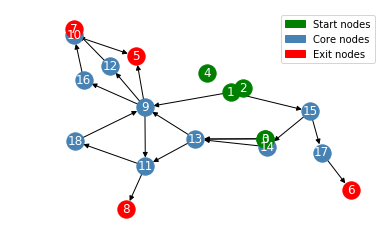

In [8]:
g.plot()

In [44]:
state, reward = g.action()

In [45]:
# nodes congestion
state

array([[0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [46]:
reward

20.0

## Action vector

In [66]:
model.predict(state) > 0.1

array([[ True,  True,  True,  True, False, False,  True, False,  True,
        False]])

In [70]:
action_vector = model.predict(state) > 0.1

In [74]:
next_act = np.where(action_vector==True)[1] + min(g.core_nodes)

In [77]:
list(next_act)

[9, 10, 11, 12, 15, 17]

In [179]:
epsilon = 0.5
def act(state):
    if np.random.rand() <= epsilon:
        # random action
#         print('random')
        k = random.randrange(0,len(g.core_nodes))
        return random.sample(g.core_nodes, k)
    else:
        # predicted action
#         print('predicted')
        action_vector = model.predict(state) > 0.5
        next_act = np.where(action_vector == True)[1] + min(g.core_nodes)
        return list(next_act)

In [188]:
act(state)

random


[10, 16, 18, 15, 17]

## get next state and reward

In [78]:
next_state, reward = g.action(list(next_act))

In [79]:
next_state

array([[0.25, 0.  , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [80]:
reward

-6.666666666666666

## Deep Q-learning with experience replay

Initialize replay memory $ \mathcal D $ to capacity $\mathrm N $
Initialize action-value function $\mathcal Q$ with random weights

$\quad$ **for** $episode = 1, M $ **do**   
$\quad$ Initialize sequence $ s_1 = \{x_1\}$ and preprocessed sequenced $ \phi_1 = \phi(s_1)$  
$\quad$ $\quad$ **for** $ t = 1, T $ **do**  
$\quad$ $\quad$ $\quad$ With probability $\epsilon$ to select a random action $ a_t $ or predicted action $ a_t = max_a Q^*(\phi(s_t),a; \theta) $  
$\quad$ $\quad$ $\quad$ Execute action $a_t$ and observe reward $r_t$ and state $x_{t+1}$  
$\quad$ $\quad$ $\quad$ Set $s_{t+1} = s_t, a_t, x_{t+1}$  and preprocess $\phi_{t+1} = \phi(s_{t+1})$  
$\quad$ $\quad$ $\quad$ Store transition $(\phi_t, a_t, r_t, \phi_{t+1}) \,\, in \,\, \mathcal D $  
$\quad$ $\quad$ $\quad$ Sample random minibatch transitions $(\phi_j, a_j, r_j, \phi_{j+1}$ from $\mathcal D$  
$\quad$ $\quad$ $\quad$ Set $ y_i = \bigg\{^{r_j}_{r_j + \gamma max_{a'}Q(\phi_{j+1}, a'; \theta)} $ for terminal or non terminal $\phi_{j+1}$, respectively  
$\quad$ $\quad$ $\quad$ Perform gradient descent step on $(y_i - Q(\phi_j, a_j; \theta))^2 $  
$\quad$ $\quad$ **end for**  
$\quad$ **end for**  

$\phi$ is a function producing a fixed length representation of histories.  
$s_t$ is the finite sequence of observation and actions $ x_1, a_1, x_2, \ldots , a_{t-1}, x_t $ at time $t$  
$Q^*(s,a)$ is the maximum expected return achievable by following any strategy after some sequence $s$ and action $a$
$$ Q^*(s,a) = max_\pi \mathbb E \left[R_t \,\rvert\, s_t = s, a_t = a, \pi \right] $$  
where $\pi$ is the policy mapping sequences to actions.  


## Model $Q(\theta)$

`input` = $s_t$  
`output` = $a_t$  


## Define action space

In [152]:
# for 10 nodes
core_nodes = 10
# how many combinations ?
action_space = core_nodes*(core_nodes - 1)


90

In [167]:
from itertools import product

In [171]:
action_space = list(product([0,1], repeat=10))
len(action_space)

1024

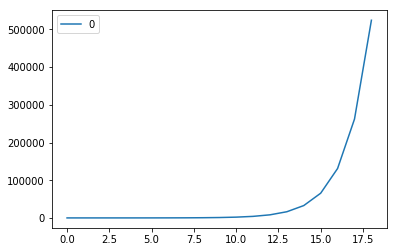

In [179]:
pd.DataFrame([len(list(product([0,1], repeat=n))) for n in range(1,20)]).plot()
plt.show()

The action space is too large when we increase the number of controllable nodes. We will limit ourself to one node per action.

In [193]:
# If we choose to block one node at a time
output_val = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.2,0.1,0.3])

In [194]:
# We choose the node with the max Q value
np.argmax(output_val)

6

In [74]:
# Choose k nodes with max proba
k = 3
np.argpartition(output_val, -k)[-k:]

array([4, 5, 6], dtype=int64)

In [75]:
# Choose threshold for action
threshold = 0.5
np.where(output_val > threshold)[0]

array([5, 6], dtype=int64)

In [76]:
epsilon = 0.5

In [205]:
def act(state, action_size):
    if np.random.rand() <= epsilon:
#         print('random')
        return [random.randrange(action_size)]
    else:
#         print('model')
        return model.predict(state)

In [218]:
act(np.zeros((1,10)), core_nodes)

array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32)

## Env interaction

In [114]:
g = RandGraph(actors=100, moving=5, n_core_nodes=10)

In [128]:
next_state, reward = g.action(act_val)

In [129]:
next_state

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.16666667, 0.        , 0.2       , 0.        , 0.        ]])

In [130]:
reward

27.27272727272727

## Memory $\mathcal D$

In [227]:
state = np.array([[0.,0.,0.0,0.,0.0,.0,.0,0.,0.,0.]])

In [228]:
# each transition is stored in D

D = []
D.append({'state':state, 'action':act_val, 'reward':reward, 'next_state':next_state})

In [229]:
D

[{'state': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
  'action': [8],
  'reward': 27.27272727272727,
  'next_state': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
          0.16666667, 0.        , 0.2       , 0.        , 0.        ]])}]

In [230]:
D[0]['reward']

27.27272727272727

In [231]:
# replay
batch_size = 1
batch = random.sample(D, batch_size)
batch

[{'state': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
  'action': [8],
  'reward': 27.27272727272727,
  'next_state': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
          0.16666667, 0.        , 0.2       , 0.        , 0.        ]])}]

## Set target

In [232]:
# discount
gamma = 0.95

In [234]:
for b in batch:
    target = b['reward'] + gamma * np.amax(model.predict(b['next_state']))
    target_f = model.predict(b['state'].reshape((1,10)))
    target_f[0][b['action']] = target
    model.fit(b['state'], target_f, epochs=1, verbose=0)

In [235]:
target_f

array([[ 0.1     ,  0.1     ,  0.1     ,  0.1     ,  0.1     ,  0.1     ,
         0.1     ,  0.1     , 27.371435,  0.1     ]], dtype=float32)

## Training

In [239]:
# initial state 0.0
state = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]).reshape((1,10))
# memory
D = []

for time_t in range(100):
    act_val  = act(state, core_nodes)
    blocked_node = [np.argmax(act_val)]
    # env interaction
    next_state, reward = g.action(blocked_node)
    next_state = np.reshape(next_state, (1,core_nodes))
    # remember
    D.append({'state':state, 'action':act_val, 'reward':reward, 'next_state':next_state})
    # move to next step
    state = next_state

../src\random_graph.py:295: RuntimeWarning: divide by zero encountered in double_scalars
  reward = len(self.core_nodes) / np.sum(values)
../src\random_graph.py:276: RuntimeWarning: invalid value encountered in double_scalars
  return values, reward - cur_rwd


In [240]:
len(D)

100

In [241]:
D

[{'state': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
  'action': array([[0.09997999, 0.09997999, 0.09997999, 0.09997999, 0.09997999,
          0.09997999, 0.09997999, 0.09997999, 0.10018014, 0.09997999]],
        dtype=float32),
  'reward': -0.23356401384083014,
  'next_state': array([[0.66666667, 0.        , 0.        , 0.14285714, 0.2       ,
          0.16666667, 0.        , 0.2       , 0.        , 0.        ]])},
 {'state': array([[0.66666667, 0.        , 0.        , 0.14285714, 0.2       ,
          0.16666667, 0.        , 0.2       , 0.        , 0.        ]]),
  'action': [2],
  'reward': 2.9941503330590713,
  'next_state': array([[0.        , 0.        , 0.        , 0.28571429, 0.        ,
          0.16666667, 0.        , 0.2       , 0.22222222, 0.1       ]])},
 {'state': array([[0.        , 0.        , 0.        , 0.28571429, 0.        ,
          0.16666667, 0.        , 0.2       , 0.22222222, 0.1       ]]),
  'action': [4],
  'reward': -5.715131773763696,
  'next_st

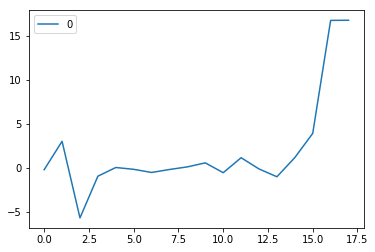

In [242]:
pd.DataFrame([n['reward'] for n in D]).plot()
plt.show()